In [7]:
import os
import scipy.io as spio
import numpy as np
from os.path import join, isdir, isfile
%matplotlib inline
import matplotlib.pyplot as plt

DATA_DIR = '../data'
# 'file_name' 'class_name' 'class' 'eng' 'mfc' 'chroma' 't'
# 'keystrength' 'brightness' 'zerocross' 'roughness' 'inharmonic' 'hcdf'

FVs = join(DATA_DIR, 'FV.mat')
LBs = join(DATA_DIR, 'LB.mat')
if not isfile(FVs) or not isfile(LBs):
    print('Generating Fisher Vectors')
    !matlab -nodisplay -nosplash -nodesktop -r "run('../tools/FV_concat.m');exit;"
else:
    print('Using existing FVs')

mfcc = np.transpose(spio.loadmat(FVs)['FV'])
labels = spio.loadmat(LBs)['LB'][0]
N = mfcc.shape[0]

p = np.random.permutation(N)
mfcc = mfcc[p]
labels = labels[p]

N

Using existing FVs


1000

In [21]:
trN = int(0.8 * N)
teN = N - trN
trX, trY = mfcc[:trN], labels[:trN]
teX, teY = mfcc[-teN:], labels[-teN:]
print(len(set(trY)))

means = np.mean(trX, axis=0)
stddevs = np.std(trX, axis=0)

def summary(x):
    return '[{:.4f}, {:.4f}]'.format(np.ndarray.min(x), np.ndarray.max(x))
print('means in range', summary(means))
print('std in range', summary(stddevs))

# Whitened data
def adjust(x): return (x - means[None, :]) / stddevs[None, :]
trXadj = adjust(trX)
teXadj = adjust(teX)

print('norm. means in range', summary(np.mean(trXadj, axis=0)))
print('norm. std in range', summary(np.std(trXadj, axis=0)))
trX.shape

10
means in range [-0.0212, 0.0078]
std in range [0.0200, 0.0627]
norm. means in range [-0.0000, 0.0000]
norm. std in range [1.0000, 1.0000]


(800, 960)

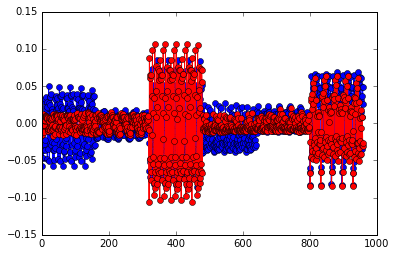

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(mfcc[0], c='b', marker="o")
ax1.plot(mfcc[1], c='r', marker="o")
plt.show()

In [22]:
# ovo multi-classification, rbf
from sklearn.svm import SVC
svm = SVC(C=1.0)
svm.fit(trXadj, trY)
print('Accuracies: train {} test {}'.format(svm.score(trXadj, trY), svm.score(teXadj, teY)))

Accuracies: train 0.9825 test 0.705


In [33]:
from sklearn.cross_validation import StratifiedKFold
Cs = [10 ** i for i in range(-5,6)]
skf = StratifiedKFold(trY,n_folds=len(Cs))
best_score, best_model, best_c = -np.inf, None, None
for (train_index, test_index), C in zip(skf, Cs):
    trXcv, trYcv = trXadj[train_index], trY[train_index]
    teXcv, teYcv = trXadj[test_index], trY[test_index]
    svm = SVC(C=C)
    svm.fit(trXcv, trYcv)
    # TODO plot test / train err over C...
    score = svm.score(teXcv, teYcv)
    if score > best_score:
        best_score = score
        best_c = C
        best_model = svm
print('Accuracies: train {} test {} (best C = {})'.format(
        svm.score(trXadj, trY), svm.score(teXadj, teY), best_c))

Accuracies: train 0.975 test 0.7 (best C = 10)


In [ ]:
# TODO: Stanform mSVM http://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
# TODO: binary search classifier.